In [1]:
import os

import math
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import ModelSummary
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryPrecisionRecallCurve
from torchvision.transforms import v2

import timm

import numpy as np
import matplotlib.pyplot as plt

# from training.hyperparameter_tuning import TLOptunaTrainer

import torch.nn.functional as F
from torchvision.utils import make_grid
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

from preprocessing.preprocessing import save_rabbit_crops

import data.custom_transforms as custom_transforms
from data.datamodule import BinaryImageDataModule
from data.datamodule import MultiClassImageDataModule

from models.model_transferlearning import TransferLearningModule, TL_ConvNextV2, TL_EfficientNetB4, TL_ResNet152D
from models.model_cnn import KaninchenModel_v3, KaninchenModel_v19

from config.load_configuration import load_configuration
config = load_configuration()

pl.seed_everything(config['seed'])
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"       # disable oneDNN optimizations for reproducibility
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"     # otherwise matplotlib may crash

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Torch Version: ', torch.__version__)
print('Using device: ', device)
if device.type == 'cuda':
    print('Cuda Version: ', torch.version.cuda)
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    torch.set_float32_matmul_precision('high')

C:\Users\Lukas Pelz\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Lukas Pelz\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Seed set to 42


PC Name: LAPTOP-PLZ
Loaded configuration from config/config_lukas_laptop.yaml
Torch Version:  2.7.1+cpu
Using device:  cpu


In [15]:
# base_path = "D:/HKA_IMS_Drive/"
# base_path = "C:/Users/lukas/SynologyDrive_IMS/"
base_path = "C:/Users/Lukas Pelz/HKA-IMS/"
model_folder = "SS25_MSYS_KAER-AI-PoseAct/21_Test_Data/Models/selected_models/"

def get_kaninchenmodel_v3():
    path = base_path + model_folder + "KaninchenModel_v3_bs32_img128_optAdamW_lr2e-04_wd6e-03_sch_StepLR_2025-06-12_12-16.ckpt"
    config['image_size'] = 128
    return KaninchenModel_v3.load_from_checkpoint(path)

def get_kaninchenmodel_v19():
    path = base_path + model_folder + "KaninchenModel_v19_bs48_img128_optAdamW_lr2e-04_wd3e-03_sch_StepLR_2025-06-13_14-17.ckpt"
    config['image_size'] = 128
    return KaninchenModel_v19.load_from_checkpoint(path)

def get_tl_convnextv2():
    path = base_path + model_folder + "TL_ConvNextV2_base_cls2_bs128_img224_optAdam_lr4e-03_wd1e-04_sch_StepLR_2025-06-17_17-31.ckpt"
    config['image_size'] = 128
    return TL_ConvNextV2.load_from_checkpoint(path, amount_of_trainable_linear_layers=2)

def get_tl_efficientnetb4():
    path = base_path + model_folder + "TL_EfficientNetB4_cls2_bs32_img380_optAdamW_lr8e-04_wd1e-05_sch_CosineAnnealingLR_2025-06-26_16-03.ckpt"
    config['image_size'] = 380
    return TL_EfficientNetB4.load_from_checkpoint(path, amount_of_trainable_linear_layers=2)

def get_tl_resnet152d():
    path = base_path + model_folder + "TL_ResNet50D_cls2_bs64_img256_optAdamW_lr2e-03_wd2e-04_sch_StepLR_2025-06-17_14-06.ckpt"
    config['image_size'] = 256
    return TL_ResNet152D.load_from_checkpoint(path, amount_of_trainable_linear_layers=2)

# Load the pretrained model from checkpoint
# model = get_kaninchenmodel_v3()
# model = get_kaninchenmodel_v19()
model = get_tl_convnextv2()
# model = get_tl_efficientnetb4()
# model = get_tl_resnet152d()

## Single Image Processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


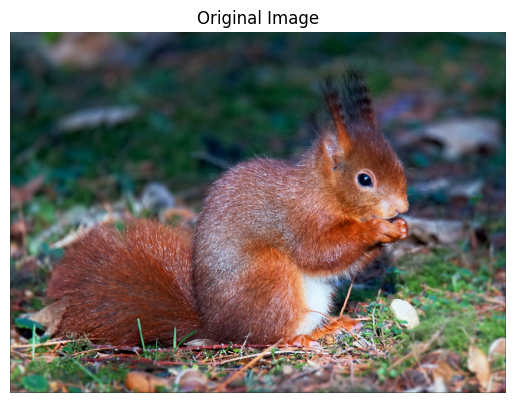

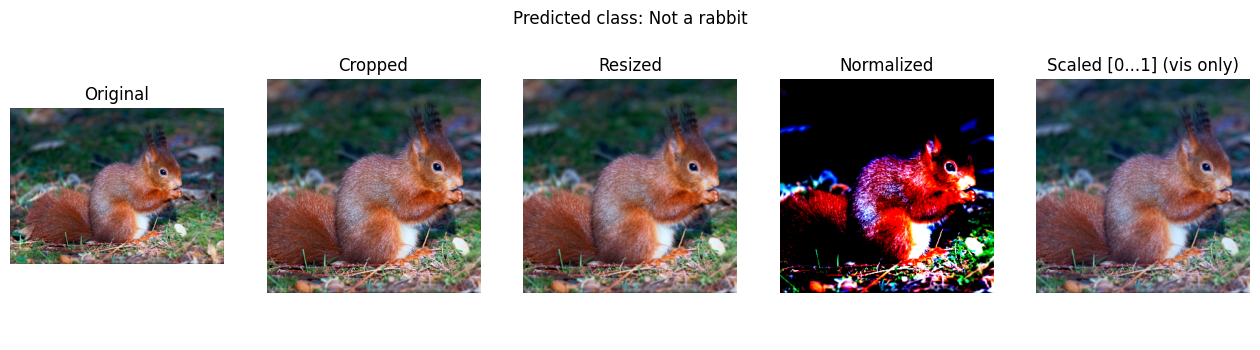

In [14]:
from PIL import Image
import os

# Path to the image you want to predict
# single_image_path = r"F:\Users\Mika\Documents\Studium_HKA\Semester2\HKA_VDKI\Mika_Data\ApolloSelene\Sources\IMG_7049.JPEG"  # Change this to your image path
# single_image_path = r"C:\Users\lukas\SynologyDrive_IMS\SS25_MSYS_KAER-AI-PoseAct\21_Test_Data\dataset_aufgabe1_raw\02_Kein_Kaninchen\Eichhoernchen_0004_nok.jpg"
single_image_path = r"C:\Users\Lukas Pelz\HKA-IMS\SS25_MSYS_KAER-AI-PoseAct\21_Test_Data\dataset_aufgabe1_raw\02_Kein_Kaninchen\Eichhoernchen_0004_nok.jpg"

# Check if the path is a file or a directory and create a list of files accordingly
if os.path.isfile(single_image_path):
    files = [single_image_path]
elif os.path.isdir(single_image_path):
    # Collect all image files in the directory (common image extensions)
    exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    files = [os.path.join(single_image_path, f) for f in os.listdir(single_image_path) if f.lower().endswith(exts)]
else:
    files = []
    print(f"Path does not exist: {single_image_path}")

transform=v2.Compose([
        custom_transforms.CenterCropSquare(),
        v2.Resize((config['image_size'], config['image_size'])),
        v2.ToImage(), 
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
plt.imshow(Image.open(single_image_path))
plt.title("Original Image")
plt.axis('off')

# Run prediction
model.eval()
model.to(device)

config['name_list'] = ['Not a rabbit', 'Rabbit']  # For Binary classification

for file in files:
    # images = save_rabbit_crops(file)
    images = [Image.open(file).convert("RGB")]
    for img in images:
        with torch.no_grad():
            output = model(transform(img).unsqueeze(0).to(device))  # Add batch dimension
            output_sigmoid = F.sigmoid(output)  # Apply sigmoid for binary classification
            if output_sigmoid > 0.5:
                pred_class = 1
            else:
                pred_class = 0
            
        # Visualize the effect of the transformation (before normalization)
        plt.figure(figsize=(16,4))
        plt.title(f"Predicted class: {config['name_list'][pred_class]}")
        plt.axis('off')

        plt.subplot(1,5,1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        img_cropped = custom_transforms.CenterCropSquare()(img)
        plt.subplot(1,5,2)
        plt.imshow(img_cropped)
        plt.title("Cropped")
        plt.axis('off')

        img_resized = v2.Resize((300, 300))(img_cropped)
        plt.subplot(1,5,3)
        plt.imshow(img_resized)
        plt.title("Resized")
        plt.axis('off')
        
        img_tensor = v2.ToImage()(img_resized)
        img_tensor = v2.ToDtype(torch.float32, scale=True)(img_tensor)  # Convert to float32 and scale
        img_tensor_normalized = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img_tensor)
        img_normalized = img_tensor_normalized.permute(1, 2, 0).cpu().numpy()
        plt.subplot(1,5,4)
        plt.imshow(img_normalized)
        plt.title("Normalized")
        plt.axis('off')

        img_normalized_vis = (img_normalized - img_normalized.min()) / (img_normalized.max() - img_normalized.min())
        plt.subplot(1,5,5)
        plt.imshow(img_normalized_vis)
        plt.title("Scaled [0...1] (vis only)")
        plt.axis('off')
        
        plt.show()